In [1]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
import os
import sys

sns.set_style("white")
sns.set_palette("colorblind")
cbrewer = ["#e41a1c", '#377eb8', '#4daf4a','#984ea3','#ff7f00',]
sns.set_palette(cbrewer)
sys.path.insert(0, '/Users/angela/src/private/bias-in-datasets/active_learning/src')
import Evaluate
from Speedup import get_percent_speedup
from Plotter import format_plot_2ys

BASELINE_COLOR = '#377eb8'
SB_COLOR = "#e7298a"
RANDOM_COLOR = '#4daf4a'
STALE_COLOR = '#984ea3'
OTHER_COLOR = "#d95f02"

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')


In [2]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, num_analyzed, acc, seconds_elapsed=None):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.num_forwards = num_analyzed
        self.acc = acc
        self.seconds_elapsed = seconds_elapsed

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"



def parse_line_v3(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        num_skipped_fp = int(vals[4])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
        
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        num_skipped_fp = int(vals[6])
        line_type = "test_debug"
    else:
        return None
    
    num_analyzed = num_skipped_fp + num_backprop + num_skipped
    
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, num_analyzed, acc)

def parse_line_v4(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        num_skipped_fp = int(vals[4])
        loss = float(vals[5])
        num_forwards = int(vals[6])
        acc = float(vals[7])
        seconds_elapsed = float(vals[8])
        line_type = "train_debug"
        
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        num_skipped_fp = int(vals[6])
        seconds_elapsed = float(vals[7]) 
        line_type = "test_debug"
    else:
        return None
    
    num_analyzed = num_skipped_fp + num_backprop + num_skipped
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, num_analyzed, acc, seconds_elapsed)

def parse_line_v5(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        num_skipped_fp = int(vals[4])
        loss = float(vals[5])
        num_forwards = int(vals[6])
        acc = float(vals[7])
        seconds_elapsed = float(vals[8])
        line_type = "train_debug"
        
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        num_skipped_fp = int(vals[6])
        seconds_elapsed = float(vals[7]) 
        line_type = "test_debug"
    else:
        return None
    
    num_analyzed = num_backprop + num_skipped - num_skipped_fp
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, num_analyzed, acc, seconds_elapsed)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v3":
        return parse_line_v3
    if version == "v4":
        return parse_line_v4
    if version == "v5":
        return parse_line_v5
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [3]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)(_seed\d+)?")
    def __init__(self, filename, experiment_name):

        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        if groups[6] == "0.0005":
            self.prob_pow = 3
        else:
            self.prob_pow = groups[6]
        self.seed = None
        self.experiment_name = experiment_name
        unparsed_trial = groups[7]
        self.trial = int(unparsed_trial.strip("_trial"))
        if groups[8]:
            unparsed_seed = groups[8]
            self.seed = int(unparsed_seed.strip("_seed"))
    
    @property
    def selectivity(self):
        if self.strategy == "nofilter":
            return 100
        else:
            return round(100 / (float(self.prob_pow) + 1), 0)
            
    @property
    def color(self):
        if self.strategy == "sb-random-alwayson":
            color = RANDOM_COLOR
        elif self.strategy == "sb-relative-alwayson":
            color = SB_COLOR
        elif "sb-relative-stale" in self.strategy:
            color = STALE_COLOR
        elif self.strategy == "nofilter":
            color = BASELINE_COLOR
        else:
            color = OTHER_COLOR
        return color
        
    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, {}, top_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.pool_size),
                                                      self.lr)
        elif self.strategy == "lowk":
            label = "{}, {}, {}, lowest_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.pool_size),
                                                      self.lr)
        elif self.strategy == "randomk":
            label = "{}, {}, {}, random_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.pool_size),
                                                      self.lr)
        elif self.strategy in ["kath-baseline", "kath-biased", "kath-reweighted"]:
            label = "Kath18, max {:0.0f}% selective".format(self.selectivity)
        elif self.strategy == "sb-relative-alwayson":
            label = "SB, {:0.0f}% selective".format(self.selectivity)
        elif self.strategy == "sb-async-relative-alwayson":
            label = "SB-async, {:0.0f}% selective".format(self.selectivity)
        elif self.strategy == "sb-random-alwayson":
            label = "Random, {:0.0f}% selective".format(self.selectivity)
        elif "sb-relative-stale" in self.strategy:
            staleness = int(self.strategy[-1])
            label = "Stale-SB (n={}), {:0.0f}% selective".format(staleness, self.selectivity)
        elif self.strategy == "nofilter":
            label = "Traditional 100% selective"

        #if self.seed:
        #    label += ", seed-{}".format(self.seed)
        #else:
        #    label += ", trial-{}".format(self.trial)
        return label
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    
def write_file(plot_file_prefix, show=False):

    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    print(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    
    if show:
        plt.show()
        
    plt.clf()

def format_plot(xlabel, ylabel, label_size=10, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * 1.2)
    plt.tick_params(axis='x', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * 1.2)

    plt.xlabel(xlabel, fontsize=label_size * 1.6)
    plt.ylabel(ylabel, fontsize=label_size * 1.6)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    
    leg = plt.legend(loc=0, prop={'size': label_size * 1.5})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)


In [21]:

def plot(xs_by_config,
         ys_by_config,
         xlabel, ylabel,
         plot_dir,
         smoothing=0,
         lw=1,
         ymin=None,
         ymax=None,
         xmax=None,
         ymarker=None,
         ylog=False,
         annotate_accuracy=False,
         annotate_error=False,
         target_errors=None,
         pin_color=False):
    local_xmax = - float("inf")
    local_ymax = - float("inf")
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].label):
        if len(ys) == 0:
            print "No elements for {} in {}".format(config.label, ylabel)
            continue
            
        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]
        
        #TODO get label here
        label = config.label
        if annotate_accuracy:
            label += ", Acc:{}".format(max(ys))
        if annotate_error:
            label += ", Error:{:0.2f}%".format(min(ys) * 100.)

        if pin_color:
            plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.9, zorder=0, c=config.color)
        else:
            plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.9, zorder=0)

        if max(xs) > local_xmax:
            local_xmax = max(xs)
        if max(ys) > local_ymax:
            local_ymax = max(ys)
        if xmax:
            plt.xlim(right = xmax)
        if ymin is not None:
            if ymax is not None:
                plt.ylim(ymin, ymax)
            else:
                plt.ylim(ymin, local_ymax + 0.1)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    if len(ys_by_config.keys()) > 0:
        plot_prefix = "{}/{}_{}".format(plot_dir,
                                        xlabel,
                                        ylabel).replace(" ", "-")
        if ylog:
            #plt.yscale("log")
            ax = plt.gca()
            ax.set_yscale("log")
            ax.minorticks_off()
            ax.set_yticks([0.01, 0.1, 0.4])
            ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        format_plot(xlabel, ylabel)
        
        if target_errors:
            for target_error in target_errors:
                plt.axhline(y=target_error, color='gray', linestyle=':', linewidth=0.2)
        write_file(plot_prefix, show=True)


In [5]:
def make_instantaneous(l):
    lcopy = l[:]
    lcopy.insert(0, 0)        
    pairs = zip(lcopy[::1], lcopy[1::1])
    ilist = [j - i for i, j in pairs]
    return ilist

def smooth(l, constant):
    for i in range(constant):
        l = [(l+r) / 2. for l, r in zip(l[:-1], l[1:])]
    return l
            
def plot_experiments(experiment_names,
                     experiments_dir,
                     plot_dir,
                     lrs=None,
                     nets=None,
                     trials=None,
                     sampling_mins=None,
                     smoothing=0,
                     pin_color=False,
                     xmax=None,
                     ymin=None,
                     ymax=None,
                     ymarker=None,
                     strategies=None,
                     batch_sizes=None,
                     prob_pows=None,
                     target_errors = None):
    
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    test_num_inferences_by_config = {}
    test_seconds_elapsed_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    test_errors_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}
    train_accuracies_by_config = {}
    ratio_backpropped_by_config_xs = {}
    ratio_backpropped_by_config_ys = {}

    for experiment_name in experiment_names:
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if ".lr" in filename or ".prof" in filename or filename == ".DS_Store" or filename == "pickles" or filename == "sha" or ".swp" in filename:
                continue
                
            print(filename)

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
            
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue
            if sampling_mins and config.top_k not in sampling_mins:
                continue
            if strategies and config.strategy not in strategies:
                continue
            if batch_sizes and config.pool_size not in batch_sizes:
                continue
            if config.strategy != "nofilter" and prob_pows and config.prob_pow not in prob_pows:
                continue

            train_num_backprops = [l.num_backprop / 1000000. for l in train_lines]
            test_num_backprops = [l.num_backprop / 1000000. for l in test_lines]
            test_num_inferences = [(l.num_forwards) / 1000000. for l in test_lines]
            train_num_inferences = [(l.num_forwards) / 1000000. for l in train_lines]

            instantaneous_train_num_backprops = make_instantaneous(train_num_backprops)
            instantaneous_train_num_inferences = make_instantaneous(train_num_inferences)

            train_losses = [l.loss for l in train_lines]
            test_losses = [l.loss for l in test_lines]
            train_accuracies = [l.acc for l in train_lines]
            test_accuracies = [l.acc for l in test_lines]
            test_errors = [(100-l.acc) / 100. for l in test_lines]
            
            test_seconds_elapsed = [l.seconds_elapsed for l in test_lines]
            
            ratio_backpropped_ys = smooth([x / float(y) \
                                           for x, y in zip(instantaneous_train_num_backprops,
                                                           instantaneous_train_num_inferences)
                                           if y > 0], 10)
            ratio_backpropped_xs = smooth([l.num_backprop / 1000000. \
                                           for l in train_lines \
                                           if (l.num_backprop + l.num_skip) > 0], 10)
            
            train_num_backprops_by_config[config] = train_num_backprops
            test_num_backprops_by_config[config] = test_num_backprops
            test_seconds_elapsed_by_config[config] = test_seconds_elapsed
            test_num_inferences_by_config[config] = test_num_inferences
            train_losses_by_config[config] = train_losses
            test_losses_by_config[config] = test_losses
            train_accuracies_by_config[config] = train_accuracies
            test_accuracies_by_config[config] = test_accuracies
            test_errors_by_config[config] = test_errors
            ratio_backpropped_by_config_xs[config] = ratio_backpropped_xs
            ratio_backpropped_by_config_ys[config] = ratio_backpropped_ys


    #plot(ratio_backpropped_by_config_xs, ratio_backpropped_by_config_ys, "Num Images Backpropped (millions)", "Ratio Backpropped", plot_dir, smoothing, lw=0.8, ymin=0, xmax=xmax)
    #plot(train_num_backprops_by_config, train_losses_by_config, "Num Images Backpropped (millions)", "Training Loss", plot_dir, smoothing, lw=1, xmax=xmax)
    plot(test_num_backprops_by_config, test_accuracies_by_config, "Num Images Backpropped (millions)", "Test Accuracy", plot_dir, smoothing, pin_color=pin_color, lw=1.3, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker, annotate_accuracy=True)
    plot(test_num_backprops_by_config, test_errors_by_config, "Num Images Backpropped (millions)", "Test Error", plot_dir, smoothing, pin_color=pin_color, lw=1.3, ymin=ymin, ymax=ymax, xmax=xmax,  ymarker=ymarker, ylog=False, target_errors=target_errors, annotate_error=True)
    plot(test_num_inferences_by_config, test_errors_by_config, "Num Images Forward Propped (millions)", "Test Error", plot_dir, smoothing, pin_color=pin_color, lw=1.3, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker, ylog=False, target_errors=target_errors, annotate_error=True)
    plot(test_seconds_elapsed_by_config, test_errors_by_config, "Seconds elapsed", "Test Error", plot_dir, smoothing, pin_color=pin_color, lw=1.3, ymin=ymin, ymax=ymax, xmax=xmax,  ymarker=ymarker, ylog=False, target_errors=target_errors, annotate_error=True)
    plot(test_num_backprops_by_config, test_losses_by_config, "Num Images Backpropped (millions)", "Test Loss", plot_dir, smoothing, pin_color=pin_color,lw=1.3, xmax=xmax)

In [24]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def is_pareto(point, comparison_points):
    x = point[0]
    y = point[1]
    for (comparison_x, comparison_y) in comparison_points:
        if comparison_x < x and comparison_y < y:
            return False
    return True

def get_color_and_marker(strategy):
    
    if "random" in strategy:
        color = RANDOM_COLOR
        marker = "x"
    elif "Stale-SB" in strategy:
        color = STALE_COLOR
        marker = "D"
    elif "SB" in strategy:
        color = SB_COLOR
        marker = "v"
    elif "NoFilter" in strategy:
        color = BASELINE_COLOR
        marker = "o"
    elif "Kath" in strategy:
        color = "#d95f02"
        marker = "X"
    elif "Random" in strategy:
        color = RANDOM_COLOR
        marker = "d"
    return color, marker

def plot_convex_hull(experiment_names,
                     experiments_dir,
                     plot_dir,
                     plot_label,
                     lrs=None,
                     nets=None,
                     trials=None,
                     prob_powses=None,
                     strategieses=None,
                     batch_sizes=None):
    max_x = 0
    max_y = 0
    all_pairs = []
    all_strategies = []
    pairs_by_strategy = {}
    ax = plt.subplot(111)
    for experiment_name, prob_pows, strategies in zip(experiment_names, prob_powses, strategieses):
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if ".lr" in filename or ".prof" in filename or filename == ".DS_Store" or filename == "pickles" or filename == "sha" or ".swp" in filename:
                continue
            #print(filename)

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
            
            if trials and config.trial not in trials:
                continue
            if strategies and config.strategy not in strategies:
                continue
            if batch_sizes and config.pool_size not in batch_sizes:
                continue
            if "nofilter" not in config.strategy and prob_pows and config.prob_pow not in prob_pows:
                continue
                
            # Hack because lr1-svhn had a different staleness than lr3
            if "stale" in config.strategy:
                config.label = "Stale-SB, {:0.0f}% selective".format(config.selectivity)

            test_seconds_elapsed = [l.seconds_elapsed for l in test_lines]
            test_error_percentages = [(100-l.acc) for l in test_lines]
            
            for err, sec in zip(test_error_percentages, test_seconds_elapsed):
                all_pairs.append([sec, err])
                key = config.label
                all_strategies.append(key)
                
                if key not in pairs_by_strategy:
                    pairs_by_strategy[key] = []
                pairs_by_strategy[key].append([sec, err])
    pareto_pairs_by_strategy = {}
    non_pareto_pairs_by_strategy = {}
    count_by_strategy = {}
    total_points = 0
    for pair, strategy in zip(all_pairs, all_strategies):
        if is_pareto(pair, all_pairs):
            if strategy not in pareto_pairs_by_strategy:
                pareto_pairs_by_strategy[strategy] = []
                count_by_strategy[strategy] = 0
            pareto_pairs_by_strategy[strategy].append(pair)
            count_by_strategy[strategy] += 1
            total_points += 1
        else:
            if strategy not in non_pareto_pairs_by_strategy:
                non_pareto_pairs_by_strategy[strategy] = []
            non_pareto_pairs_by_strategy[strategy].append(pair)
            
    for strategy, strategy_pairs in sorted(non_pareto_pairs_by_strategy.iteritems(), key=lambda x: x[0]):
        c, m = get_color_and_marker(strategy)
        ax.scatter([], [], color=c, marker=m, s=60, label=strategy, zorder=0)

    for strategy, strategy_pairs in sorted(non_pareto_pairs_by_strategy.iteritems(), key=lambda x: x[0]):
        points = np.array(strategy_pairs)        
        c, m = get_color_and_marker(strategy)
        ax.scatter(points[:,0], points[:,1], color=c, marker=m, s=10, alpha=0.3, facecolors='none')
    for strategy, strategy_pairs in sorted(pareto_pairs_by_strategy.iteritems(), key=lambda x: x[0]):
        points = np.array(strategy_pairs)        
        c, m = get_color_and_marker(strategy)
        ax.scatter(points[:,0], points[:,1], color=c, marker=m, s=60, edgecolors='black')
        print("{} had {}/{} pareto points".format(strategy, count_by_strategy[strategy], total_points))
        
    ax.set_ylim(bottom=0)

    if False:
        ax.set_yscale("log")
        ax.minorticks_off()
        ax.set_yticks([10, 100])
        ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        format_plot("Wall-clock time (seconds)", "Error % (log)")
    else:
        format_plot("Wall-clock Time (seconds)", "Error Percentage")

    plot_prefix = "{}/hull-{}".format(plot_dir, plot_label)
    write_file(plot_prefix, show=True)


In [15]:
def plot_percentiles(plot_dir, files, labels, colors, styles):
    indices = [1, 2]
    ylabels = ["Target Confidence", "Percent Correct"]
    for index, ylabel in zip(indices, ylabels):
        for fname, label, color, style in zip(files, labels, colors, styles):
            xs = []
            ys = []
            with open(fname) as f:
                for line in f:
                    vals = line.rstrip().split(",")
                    x = float(vals[0])
                    y = float(vals[index])
                    xs.append(x)
                    ys.append(y)
            plt.plot(xs, ys, label=label, color=color, linestyle=style)
        format_plot("Percentile", ylabel)
        subplot_dir = os.path.join(plot_dir, ylabel)
        write_file(subplot_dir)

TypeError: zip argument #2 must support iteration

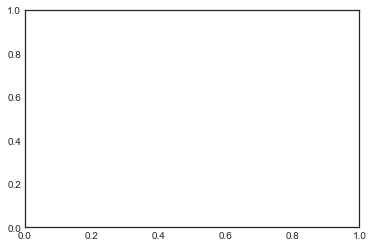

In [25]:
plot_home_dir = "../plots/"
experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/sysml20//cifar10/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

    
datasets = ["cifar10", "cifar100", "svhn"]
prob_powses = [[["2", "2.0", 2], ["2", "2.0", 2]],
               [["1", "1.0", 1], ["1", "1.0", 1]],
               [["2", "2.0", 2], ["2", "2.0", 2]]]
for dataset, (prob_pows1, prob_pows2) in zip(datasets, prob_powses):
    experiment_dir = "../data/output/{}".format(dataset)
    plot_dir = "{}/sysml20/pareto/".format(plot_home_dir)
    experiment_names = ["190904_lr1", "190904_lr3"]
    plot_convex_hull(experiment_names, experiment_dir, plot_dir, dataset, trials=[1],
                     #prob_powses = [prob_pows1, prob_pows2],
                     strategieses =[["sb-relative-stale3",
                                 "sb-relative-alwayson",
                                 "sb-random-alwayson",
                                 "nofilter",
                                 "kath-biased"
                                ], ["sb-relative-stale2",
                                 "sb-relative-alwayson",
                                 "sb-random-alwayson",
                                 "nofilter",
                                 "kath-biased"]])


In [ ]:
# Strategy sweep 

experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/sysml20/strategy/cifar10/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)


experiment_names = ["190904_lr1"]
if False:
    plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                     prob_pows = ["2", "2.0", 2],
                     pin_color = True,
                     ymin=0,
                     strategies=["sb-relative-alwayson",
                                 "sb-relative-stale3",
                                 #"sampling-random",
                                 "nofilter",
                                 "kath-biased"
                                    ])

experiment_dir = "../data/output/cifar100/"
plot_dir = "{}/sysml20/strategy/cifar100/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["190904_lr1"]
if False:
    plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                     prob_pows = ["1", "1.0", 1],
                     pin_color = True,
                     ymin=0,
                     strategies=["sb-relative-alwayson",
                                 "sb-relative-stale3",
                                 #"sb-random-alwayson",
                                 "nofilter",
                                 "kath-biased"
                                ])
        
experiment_dir = "../data/output/svhn/"
plot_dir = "{}/sysml20/strategy/svhn/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["190904_lr1"]
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                     prob_pows = ["2", "2.0", 2],
                     pin_color = True,
                     ymin=0,
                     strategies=["sb-relative-alwayson",
                                 "sb-relative-stale3",
                                 #"sb-random-alwayson",
                                 "nofilter",
                                 "kath-biased"
                                ])

In [ ]:
# Selectivity sweep 

experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/sysml20/selectivity/cifar10/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

prob_pows = ["1", "1.0", "2", "2.0", "4", "4.0"]
experiment_names = ["190904_lr1"]
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                     ymin=0,
                     prob_pows = prob_pows,
                     strategies=["sb-relative-alwayson",
                                     #"sb-relative-stale2",
                                     "nofilter",
                                     #"kath-biased"
                                    ])

experiment_dir = "../data/output/cifar100/"
plot_dir = "{}/sysml20/selectivity/cifar100/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["190904_lr1"]
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                     ymin=0,
                     prob_pows = prob_pows,
                     strategies=["sb-relative-alwayson",
                                     #"sb-relative-stale2",
                                     "nofilter",
                                     #"kath-biased"
                                ])
        
experiment_dir = "../data/output/svhn/"
plot_dir = "{}/sysml20/selectivity/svhn/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["190904_lr1"]
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                     ymin=0,
                     prob_pows = prob_pows,
                     strategies=["sb-relative-alwayson",
                                     #"sb-relative-stale2",
                                     #"sampling-random",
                                     "nofilter",
                                     #"kath-biased"
                                ])

kath-biased_cifar10_wideresnet_0_128_256_1_trial1_seed1337_v5
kath-biased_cifar10_wideresnet_0_128_384_2_trial1_seed1337_v5
kath-biased_cifar10_wideresnet_0_128_512_3.0_trial1_seed1337_v5
kath-biased_cifar10_wideresnet_0_128_512_3_trial1_seed1337_v5
kath-biased_cifar10_wideresnet_0_128_640_4_trial1_seed1337_v5
nofilter_cifar10_wideresnet_0_128_1024_3_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_1.0_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_2.0_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_3.0_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_4.0_trial1_seed1337_v5
sb-relative-alwayson_cifar10_wideresnet_0_128_1024_1.0_trial1_seed1337_v5
sb-relative-alwayson_cifar10_wideresnet_0_128_1024_2.0_trial1_seed1337_v5
sb-relative-alwayson_cifar10_wideresnet_0_128_1024_3.0_trial1_seed1337_v5
sb-relative-alwayson_cifar10_wideresnet_0_128_1024_4.0_trial1_seed1337_v5
sb-relative-stale2_cifar10_wideresnet_0_128_

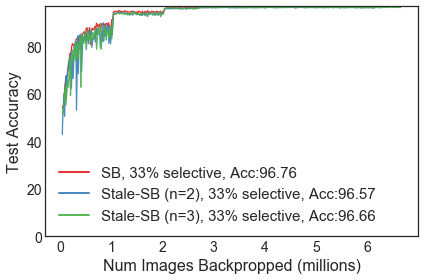

../plots//sysml20/staleness/cifar10//Num-Images-Backpropped-(millions)_Test-Error.pdf


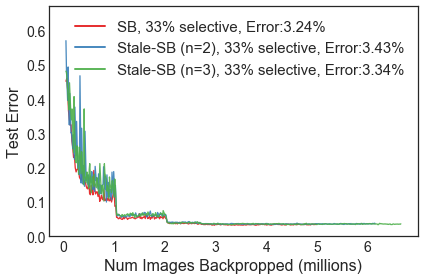

../plots//sysml20/staleness/cifar10//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


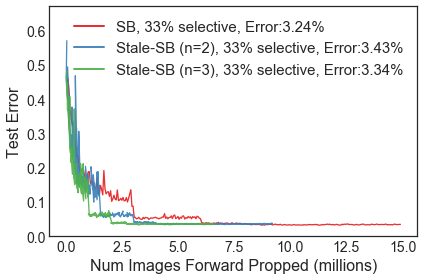

../plots//sysml20/staleness/cifar10//Seconds-elapsed_Test-Error.pdf


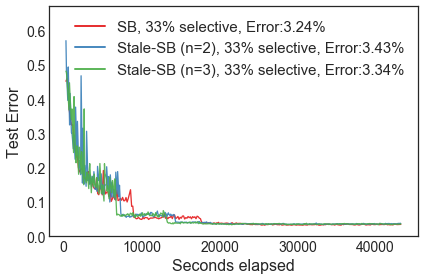

../plots//sysml20/staleness/cifar10//Num-Images-Backpropped-(millions)_Test-Loss.pdf


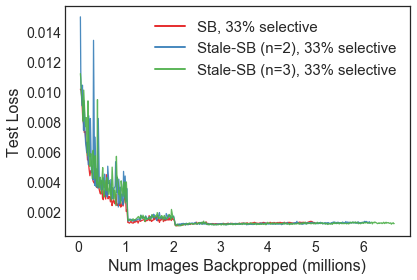

kath-biased_cifar100_wideresnet_0_128_192_0.5_trial1_seed1337_v5
kath-biased_cifar100_wideresnet_0_128_256_1.0_trial1_seed1337_v5
kath-biased_cifar100_wideresnet_0_128_384_2.0_trial1_seed1337_v5
kath-biased_cifar100_wideresnet_0_128_512_3.0_trial1_seed1337_v5
nofilter_cifar100_wideresnet_0_128_1024_3_trial1_seed1337_v5
sb-random-alwayson_cifar100_wideresnet_0_128_1024_0.5_trial1_seed1337_v5
sb-random-alwayson_cifar100_wideresnet_0_128_1024_1.0_trial1_seed1337_v5
sb-random-alwayson_cifar100_wideresnet_0_128_1024_2.0_trial1_seed1337_v5
sb-random-alwayson_cifar100_wideresnet_0_128_1024_3.0_trial1_seed1337_v5
sb-relative-alwayson_cifar100_wideresnet_0_128_1024_0.5_trial1_seed1337_v5
sb-relative-alwayson_cifar100_wideresnet_0_128_1024_1.0_trial1_seed1337_v5
sb-relative-alwayson_cifar100_wideresnet_0_128_1024_2.0_trial1_seed1337_v5
sb-relative-alwayson_cifar100_wideresnet_0_128_1024_3.0_trial1_seed1337_v5
sb-relative-stale2_cifar100_wideresnet_0_128_1024_0.5_trial1_seed1337_v5
sb-relative-st

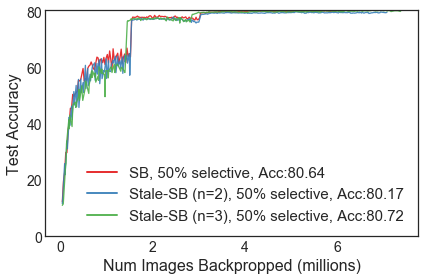

../plots//sysml20/staleness/cifar100//Num-Images-Backpropped-(millions)_Test-Error.pdf


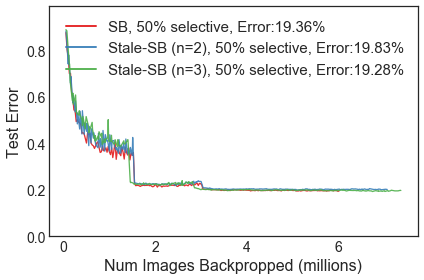

../plots//sysml20/staleness/cifar100//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


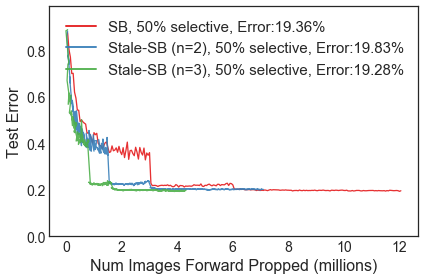

../plots//sysml20/staleness/cifar100//Seconds-elapsed_Test-Error.pdf


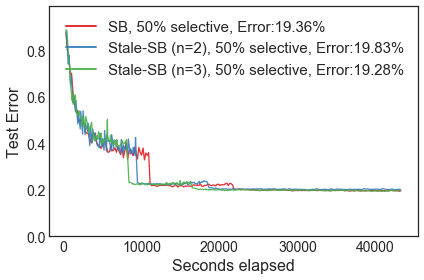

../plots//sysml20/staleness/cifar100//Num-Images-Backpropped-(millions)_Test-Loss.pdf


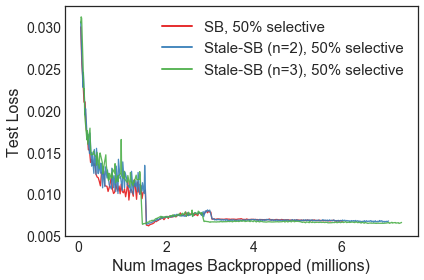

kath-biased_svhn_wideresnet_0_128_256_1.0_trial1_seed1337_v5
kath-biased_svhn_wideresnet_0_128_384_2.0_trial1_seed1337_v5
kath-biased_svhn_wideresnet_0_128_512_3.0_trial1_seed1337_v5
kath-biased_svhn_wideresnet_0_128_640_4.0_trial1_seed1337_v5
nofilter_svhn_wideresnet_0_128_1024_3_trial1_seed1337_v5
sb-random-alwayson_svhn_wideresnet_0_128_1024_1.0_trial1_seed1337_v5
sb-random-alwayson_svhn_wideresnet_0_128_1024_2.0_trial1_seed1337_v5
sb-random-alwayson_svhn_wideresnet_0_128_1024_3.0_trial1_seed1337_v5
sb-random-alwayson_svhn_wideresnet_0_128_1024_4.0_trial1_seed1337_v5
sb-relative-alwayson_svhn_wideresnet_0_128_1024_1.0_trial1_seed1337_v5
sb-relative-alwayson_svhn_wideresnet_0_128_1024_2.0_trial1_seed1337_v5
sb-relative-alwayson_svhn_wideresnet_0_128_1024_3.0_trial1_seed1337_v5
sb-relative-alwayson_svhn_wideresnet_0_128_1024_4.0_trial1_seed1337_v5
sb-relative-stale2_svhn_wideresnet_0_128_1024_1.0_trial1_seed1337_v5
sb-relative-stale2_svhn_wideresnet_0_128_1024_2.0_trial1_seed1337_v5
s

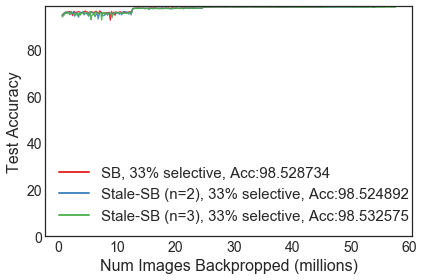

../plots//sysml20/staleness/svhn//Num-Images-Backpropped-(millions)_Test-Error.pdf


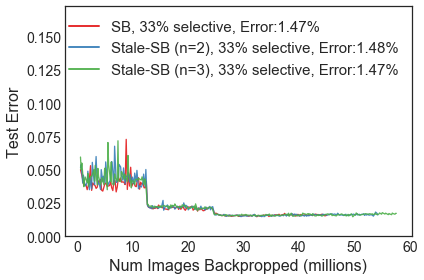

../plots//sysml20/staleness/svhn//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


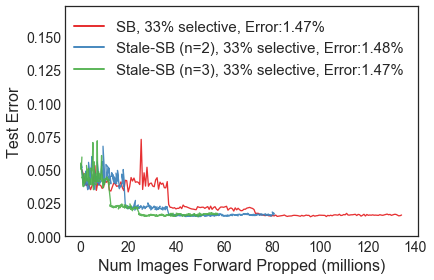

../plots//sysml20/staleness/svhn//Seconds-elapsed_Test-Error.pdf


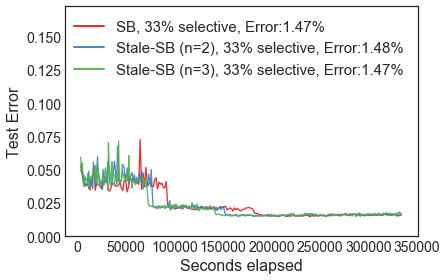

../plots//sysml20/staleness/svhn//Num-Images-Backpropped-(millions)_Test-Loss.pdf


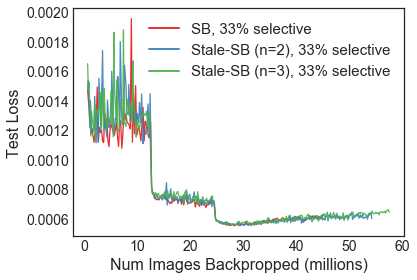

<Figure size 432x288 with 0 Axes>

In [23]:
# Staleness sweep 

experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/sysml20/staleness/cifar10/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)


experiment_names = ["190904_lr1"]
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                     ymin=0,
                     #xmax=10,
                     prob_pows = ["2", "2.0", 2],
                     strategies=["sb-relative-alwayson",
                                 "sb-relative-stale2",
                                 "sb-relative-stale3",
                                     #"nofilter",
                                     #"kath-biased"
                                    ])

experiment_dir = "../data/output/cifar100/"
plot_dir = "{}/sysml20/staleness/cifar100/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["190904_lr1"]
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                     ymin=0,
                     #xmax=8,
                     prob_pows = ["1", "1.0", 1],
                     strategies=["sb-relative-alwayson",
                                 "sb-relative-stale2",
                                 "sb-relative-stale3",
                                  #"nofilter",
                                  #"kath-biased"
                                ])
        
experiment_dir = "../data/output/svhn/"
plot_dir = "{}/sysml20/staleness/svhn/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["190904_lr1"]
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                     ymin=0,
                     #xmax=90,
                     prob_pows = ["2", "2.0", 2],
                     strategies=["sb-relative-alwayson",
                                 "sb-relative-stale2",
                                 "sb-relative-stale3",
                                     #"sampling-random",
                                     #"nofilter",
                                     #"kath-biased"
                                ])

In [17]:
curdir1="../data/output/cifar10/190906_confidences_nofilter/"
#write_percentiles_by_file(curdir+"target_confidences/target_confidences.pickle", "nofilter", curdir1, max_epoch=100)

curdir2="../data/output/cifar10/190906_confidences_sb/"
#write_percentiles_by_file(curdir+"target_confidences/target_confidences.pickle", "sb", curdir2, max_epoch=100)


files = ["../data/output/cifar10/190906_confidences_nofilter/nofilter_epoch7_400000backpropped.txt",
         "../data/output/cifar10/190906_confidences_sb/sb_epoch21_399512backpropped.txt"]

files = ["../data/output/cifar10/190906_confidences_nofilter/nofilter_epoch9_500000backpropped.txt",
         "../data/output/cifar10/190906_confidences_sb/sb_epoch27_499270backpropped.txt"]

labels = ["NoFilter",
          "SB",
         ]
colors = [BASELINE_COLOR, SB_COLOR]
styles = ["--", "-"]
plot_dir = "../plots/batch_stats/190906_confidences/"
plot_percentiles(plot_dir, files, labels, colors, styles)

../plots/batch_stats/190906_confidences/Target Confidence.pdf
../plots/batch_stats/190906_confidences/Percent Correct.pdf


<Figure size 432x288 with 0 Axes>

In [ ]:
# labelerror sweep 

experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/sysml20/labelerror/0.2/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["190906_labelerror_0.2"]
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, pin_color=True, trials=[1], ymin=0)
    
experiment_names = ["190906_labelerror_0.1"]
plot_dir = "{}/sysml20/labelerror/0.1/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, pin_color=True, trials=[1], ymin=0)

plot_dir = "{}/sysml20/labelerror/0.01".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["190906_labelerror_0.01"]
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, pin_color=True, trials=[1], ymin=0)
        
plot_dir = "{}/sysml20/labelerror/0.001".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["190906_labelerror_0.001"]
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, pin_color=True, trials=[1],ymin=0)

In [ ]:
# lr3

plot_home_dir = "../plots/"
experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/sysml20//cifar10/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

    
datasets = ["cifar10", "cifar100", "svhn"]
prob_powses = [["2", "2.0", 2], ["1", "1.0", 1], ["3", "3.0", 3]]
for dataset, prob_pows in zip(datasets, prob_powses):
    experiment_dir = "../data/output/{}".format(dataset)
    plot_dir = "{}/sysml20/pareto_lr3/".format(plot_home_dir)
    #experiment_names = ["190904_lr1", "190904_lr3"]
    experiment_names = ["190904_lr3"]
    plot_convex_hull(experiment_names, experiment_dir, plot_dir, dataset, trials=[1],
                     prob_pows = prob_pows,
                     strategies=["sb-relative-stale2",
                                 "sb-relative-alwayson",
                                 "sb-random-alwayson",
                                 "nofilter",
                                 "kath-biased"
                                ])


In [ ]:
# LR3 strategy sweep 

experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/sysml20/strategy_lr3/cifar10/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)


experiment_names = ["190904_lr3"]
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                     prob_pows = ["2", "2.0", 2],
                     pin_color = True,
                     ymin=0,
                     strategies=["sb-relative-alwayson",
                                 "sb-relative-stale3",
                                 #"sampling-random",
                                 "nofilter",
                                 "kath-biased"
                                    ])

experiment_dir = "../data/output/cifar100/"
plot_dir = "{}/sysml20/strategy_lr3/cifar100/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["190904_lr3"]
if True:
        plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                     prob_pows = ["1", "1.0", 1],
                     pin_color = True,
                     ymin=0,
                     strategies=["sb-relative-alwayson",
                                 "sb-relative-stale3",
                                 #"sb-random-alwayson",
                                 "nofilter",
                                 "kath-biased"
                                ])
        
experiment_dir = "../data/output/svhn/"
plot_dir = "{}/sysml20/strategy_lr3/svhn/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["190904_lr3"]
if True:
    plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                     prob_pows = ["3", "3.0"],
                     pin_color = True,
                     ymin=0,
                     strategies=["sb-relative-alwayson",
                                 "sb-relative-stale3",
                                 #"sb-random-alwayson",
                                 "nofilter",
                                 "kath-biased"
                                ])